# IMDB sentiment prediction with pytorch

I'm reading the material in the keras book but implementing in pytorch.

I'm using [polarity data set v2.0](https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) to predict binary: positive or negative review. The data uncompressed it looks like:

```
data/review_polarity/txt_sentoken/
├── neg
│   ├── cv000_29416.txt
│   ├── cv001_19502.txt
│   ├── cv002_17424.txt
│   ├── cv003_12683.txt
│   ├── cv004_12641.txt
...
```

Instead of trying to learn the ancillary package torchtext, I'm going to use SpaCy to tokenize.

## Support code

In [20]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import codecs
import os
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def filelist(root):
    """Return a fully-qualified list of filenames under root directory; sort names alphabetically."""
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            allfiles.append(os.path.join(path, name))
    return sorted(allfiles)

def get_text(filename:str):
    """
    Load and return the text of a text file, assuming latin-1 encoding as that
    is what the BBC corpus uses.  Use codecs.open() function not open().
    """
    f = codecs.open(filename, encoding='latin-1', mode='r')
    s = f.read()
    f.close()
    return s

def load_docs(docs_dirname:str):
    """
    Load all .txt files under docs_dirname and return a list of doc strings, one per doc.
    Ignore empty and non ".txt" files.
    """
    docs = []
    for filename in filelist(docs_dirname):#[0:600]:
        if not filename.endswith(".txt"): continue
        # print(f"Process {filename}")
        filetext = get_text(filename)
        if len(filetext)==0: continue
        docs.append( compress_whitespace(filetext) )
    return docs

def words(text:str):
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    Remove English stop words
    """
    ctrl_chars = '\x00-\x1f'
    regex = re.compile(r'[' + ctrl_chars + string.punctuation + '0-9\r\t\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words = nopunct.split(" ")
    words = [w for w in words if len(w) > 2]  # ignore a, an, to, at, be, ...
    words = [w.lower() for w in words]
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return words

def compress_whitespace(s): # collapse things like "\n   \t  " with " "
    return re.sub(r"(\s+)", ' ', s)

In [63]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [78]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [5]:
import torch
def pad(a, w):
    return torch.cat([a, a.new_zeros(w - a.shape[0])])

## Load movie reviews

In [ ]:
# paperspace needs this
!pip -q install spacy
!python -m spacy download en_core_web_sm

In [6]:
import spacy

In [7]:
# paperspace needs:
#!ln -s storage/data data
neg_dirname = "data/review_polarity/txt_sentoken/neg"
pos_dirname = "data/review_polarity/txt_sentoken/pos"
negdocs = load_docs(neg_dirname)
posdocs = load_docs(pos_dirname)
n_negdocs = len(negdocs)
n_posdocs = len(posdocs)
n_negdocs, n_posdocs

(1000, 1000)

In [8]:
import en_core_web_sm
nlp = en_core_web_sm.load()
# The following fails on paperspace gradient platform
#nlp = spacy.load("en_core_web_sm") # When I use plain English() it doesn't seem to give POS info

In [10]:
#neg_tokenized = [list(nlp(d)) for d in negdocs] # super slow!
#pos_tokenized = [list(nlp(d)) for d in posdocs]

neg_tokenized = [words(d) for d in negdocs] # much faster!
pos_tokenized = [words(d) for d in posdocs]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import numpy as np

ndocprefix = 20 # use first 20 words
vocab_size = 10_000
all = []
for tokens in neg_tokenized + pos_tokenized:
    all.extend([w for w in tokens])
c = Counter(all)
V = c.most_common(vocab_size)
word_to_idx = {w:i for i,w in enumerate(dict(V).keys())}
V = sorted(word_to_idx.keys())

In [14]:
# Keep only words in V, just first 20, convert to ints in word_to_idx
neg = []
pos = []
for i in range(len(neg_tokenized)):
    d = [word_to_idx[w] for w in neg_tokenized[i] if w in V][:ndocprefix]
    neg.append( pad(torch.tensor(d), ndocprefix) )
for i in range(len(pos_tokenized)):
    d = [word_to_idx[w] for w in pos_tokenized[i] if w in V][:ndocprefix]
    pos.append( pad(torch.tensor(d), ndocprefix) )

In [15]:
X = torch.stack(neg+pos)
X = X.long()
y = torch.tensor([0]*n_negdocs + [1]*n_posdocs).reshape(-1,1)
y = y.float()
X = X.to(device)
y = y.to(device)
X.shape, y.shape

(torch.Size([2000, 20]), torch.Size([2000, 1]))

## Build simple sentiment learner / predictor

The keras book uses 8 dimensional embedding vectors, 20 word prefix for each document,
10,000 most common words. They concatenate the 20 8-vectors and run that into a
single-neuron final layer. That surprises me. I tried adding a hidden layer but 
it didn't help very much. Actually, now that I play with it, epochs=150,                      learning_rate=0.03, weight_decay=0.00001, it looks like it starts to consistently get better to about 56% accuracy.

In [13]:
import torch
import torch.nn as nn

class Sentiment(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.final = nn.Linear(ndocprefix*nfactors,1)
        
    def forward(self, x):
#         print(x.device)       # cuda:0 or cpu
#         print(x.shape)      # [1600, 20]
        output = self.embedding(x)
#         print(output.shape) # [1600, 20, 8] = (samples, num word features, embedding dim)
        # must cat the 20 64-vectors together
        output = output.view((x.shape[0], -1))
#         print(output.shape) # [1600, 160]
        output = self.final(output)
#         print(output.shape) # [1600, 1]
        return torch.sigmoid(output)

In [17]:
from sklearn.metrics import accuracy_score

def train(model, X, y, epochs=350, test_size=0.20, learning_rate = 0.002, weight_decay=1.e-4, print_every=30, loss_fn=nn.BCELoss()):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    history = []
    for t in range(epochs):
        y_prob = model(X_train)
        loss = loss_fn(y_prob, y_train)
        #y_pred = torch.round(y_prob)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()
        
        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            accur_train = accuracy_score(torch.round(model(X_train).cpu()), y_train.cpu())
            accur_valid = accuracy_score(torch.round(model(X_valid).cpu()), y_valid.cpu())

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

1600 training and 400 test records
Epoch   0 log loss   0.730,   0.708   accuracy 0.558, 0.517
Epoch  20 log loss   0.036,   1.273   accuracy 1.000, 0.545
Epoch  40 log loss   0.015,   1.390   accuracy 1.000, 0.530
Epoch  60 log loss   0.011,   1.230   accuracy 1.000, 0.535
Epoch  80 log loss   0.009,   1.121   accuracy 1.000, 0.527


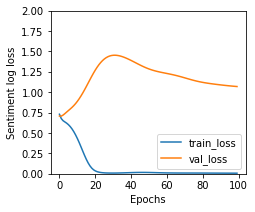

In [18]:
nfactors = 8
model = Sentiment(vocab_size, nfactors).to(device)
model, history = train(model, X, y,
                       epochs=100,
                       learning_rate=0.03,
                       weight_decay=0.0001,
                       print_every=20)

plot_history(history, yrange=(0,2.0))

That's not very good. Depending on where it initializes, I've seen it get to 60% accuracy.

## Add mini-batches

It sounds like many batches of around 32 are sort of the general recommendation to get stochastic gradient descent. See [stackoverflow](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data) and [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612).  It seems like training on the whole batch is not done for two reasons:

1.  it has to all fit in GPU memory
2.  the full batch does not add any bouncing around to the gradient descent process which gets us stuck in local minima.



In [14]:
def train(model, X, y,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    history = []

    for t in range(epochs): # epochs
        permutation = torch.randperm(X_train.shape[0])   # shuffle each epoch

        for k in range(0, X_train.shape[0], batch_size): # mini-batch
            batch_indices = permutation[k:k+batch_size]
            batch_x, batch_y = X_train[batch_indices], y_train[batch_indices]
    
            y_prob = model(batch_x)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()
        
        with torch.no_grad():
            loss        = loss_fn(model(X_train), y_train)
            loss_valid  = loss_fn(model(X_valid), y_valid)
            accur_train = accuracy_score(torch.round(model(X_train).cpu()), y_train.cpu())
            accur_valid = accuracy_score(torch.round(model(X_valid).cpu()), y_valid.cpu())

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


1600 training and 400 test records
Epoch   0 log loss   0.709,   0.726   accuracy 0.524, 0.502
Epoch  10 log loss   0.538,   0.745   accuracy 0.754, 0.535
Epoch  20 log loss   0.319,   0.862   accuracy 0.904, 0.550
Epoch  30 log loss   0.140,   1.019   accuracy 0.979, 0.557
Epoch  40 log loss   0.055,   1.164   accuracy 0.997, 0.557


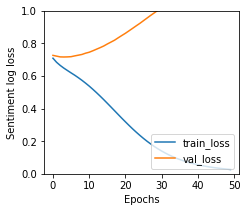

In [20]:
nfactors = 8
model = Sentiment(vocab_size, nfactors).to(device)
model, history = train(model, torch.tensor(X), torch.tensor(y),
                       epochs=50,
                       learning_rate=0.001,
                       batch_size=32,
                       weight_decay=0.000001,
                       print_every=10)

plot_history(history, yrange=(0,1.0))

Hmm...still can't get past 57%

## Use pytorch for minibatching

In [51]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class IMBD(Dataset): # unnecessary, can use TensorDataset
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class IMBD(TensorDataset):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.X = X # track with easy to use fields
        self.y = y

In [59]:
from sklearn.metrics import accuracy_score
def train(model, train_data, valid_data,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()
        
        with torch.no_grad():
            loss        = loss_fn(model(train_data.X), train_data.y)
            loss_valid  = loss_fn(model(valid_data.X), valid_data.y)
            accur_train = accuracy_score(torch.round(model(train_data.X).cpu()), train_data.y.cpu())
            accur_valid = accuracy_score(torch.round(model(valid_data.X).cpu()), valid_data.y.cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

1600 training and 400 test records
Epoch   0 log loss   0.648,   0.722   accuracy 0.630, 0.495
Epoch  10 log loss   0.092,   0.798   accuracy 1.000, 0.547
Epoch  20 log loss   0.029,   0.852   accuracy 1.000, 0.560
Epoch  30 log loss   0.028,   0.837   accuracy 1.000, 0.590
Epoch  40 log loss   0.028,   0.839   accuracy 1.000, 0.583
Epoch  50 log loss   0.028,   0.842   accuracy 1.000, 0.570
Epoch  60 log loss   0.028,   0.845   accuracy 1.000, 0.570
Epoch  70 log loss   0.028,   0.847   accuracy 1.000, 0.565
Epoch  80 log loss   0.028,   0.849   accuracy 1.000, 0.575
Epoch  90 log loss   0.028,   0.850   accuracy 1.000, 0.573


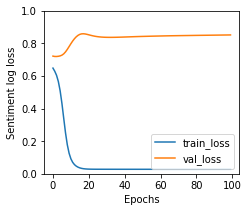

In [23]:
nfactors = 8
model = Sentiment(vocab_size, nfactors).to(device)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=100,
                       learning_rate=0.003,
                       weight_decay=0.001,
                       batch_size=16,
                       print_every=10)

plot_history(history, yrange=(0,1.0))

Still can't seem to get it above about 57%.  With batch_size=16 I saw 60% one epoch.

Switching to RMSProp seems to get consistently close to 60%

## Add more layers and dropout

In [11]:
import torch
import torch.nn as nn

layer1 = 16
layer2 = 16
class SentimentRegularized(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(SentimentRegularized, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.layers = nn.Sequential(
            nn.Linear(ndocprefix*nfactors,layer1), # 300 neurons
#            nn.BatchNorm1d(layer1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=layer1, out_features=layer2),
#            nn.BatchNorm1d(layer2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(layer2,1)
        )
        
    def forward(self, x):
        output = self.embedding(x)
        output = output.view((x.shape[0], -1))
        output = self.layers(output)
        return torch.sigmoid(output)

In [10]:
nfactors = 16
model = SentimentRegularized(vocab_size, nfactors).to(device)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=100,
                       learning_rate=0.001,
                       weight_decay=0.001,
                       batch_size=32,
                       print_every=20)

plot_history(history, yrange=(0,2.0))

NameError: name 'SentimentRegularized' is not defined

## Try RF

Can't get much above 50% accurate as expected from raw text.

In [26]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1)
rf.fit(X_train.cpu(), y_train.cpu())
print(rf.oob_score_)
accuracy_score(rf.predict(X_valid.cpu()), y_valid.cpu())

/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.516875


0.475